In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
import joblib
import time
from scipy.stats import randint, uniform

# Load data
data_path = r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Final Results\Final Data Used\final_data_filtered_ohe.csv"
df = pd.read_csv(data_path, delimiter=',')
# === Feature Engineering ===
epsilon = 1e-6
df['vm_fc_ratio'] = df['vm'] / (df['fc'] + epsilon)
df['ac_fc_ratio'] = df['ac'] / (df['fc'] + epsilon)

# === Separate test and training data ===
test_data = df[df['fuel_type'] == 'HTC-MSW'].copy()
train_data = df[df['fuel_type'] != 'HTC-MSW'].copy()

# === Define feature columns ===
feature_cols = [
    'h', 'wc', 'c', 'lhv', 'o', 'n', 's', 'cl',
    'hc', 'oc', 'temperature', 'residence_time', 'pressure', 'heat_rate',
    'vm_fc_ratio', 'ac_fc_ratio'
]

# === Expanded bounds for MinMaxScaler ===
min_vm_fc_ratio = df['vm_fc_ratio'].min()
max_vm_fc_ratio = df['vm_fc_ratio'].max()
min_ac_fc_ratio = df['ac_fc_ratio'].min()
max_ac_fc_ratio = df['ac_fc_ratio'].max()

min_values = {
    'wc': 2.6, 'vm': 44.2, 'fc': 3.064326, 'ac': 0.0, 'c': 32.4, 'h': 3.265 , 'lhv': 13.528,
    'o': 7.0, 'n': 0.269662, 's': 0.04642, 'cl': 0.0, 'hc': 0.7, 'oc': 0.0,
    'temperature': 200, 'residence_time': 0.5, 'pressure': 0.5, 'heat_rate': 10,
    'vm_fc_ratio': min_vm_fc_ratio, 'ac_fc_ratio': min_ac_fc_ratio
}
max_values = {
    'wc': 10.8, 'vm': 91.735674, 'fc': 44.5, 'ac': 37.52, 'c': 82.3, 'h': 10.13205, 'lhv': 35.8,
    'o': 54.936839, 'n': 3.9, 's': 2.5, 'cl': 1.5, 'hc': 1.857, 'oc': 1.04402,
    'temperature': 1200, 'residence_time': 20, 'pressure': 20, 'heat_rate': 1000,
    'vm_fc_ratio': max_vm_fc_ratio, 'ac_fc_ratio': max_ac_fc_ratio
}
margin_ratio = 0.4
expanded_bounds = {}
for feat in feature_cols:
    min_val = min_values[feat]
    max_val = max_values[feat]
    range_val = max_val - min_val
    new_min = max(0, min_val - range_val * margin_ratio)
    new_max = max_val + range_val * margin_ratio
    expanded_bounds[feat] = (round(new_min, 3), round(new_max, 3))

X_bounds = pd.DataFrame({col: [expanded_bounds[col][0], expanded_bounds[col][1]] for col in feature_cols})
scaler = MinMaxScaler()
scaler.fit(X_bounds)

# === Prepare X and y ===
X_train = train_data[feature_cols]
y_train = train_data['devol_yield']
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=feature_cols, index=X_train.index)

X_test = test_data[feature_cols]
y_test = test_data['devol_yield']
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=feature_cols, index=X_test.index)



# Function to evaluate and report results
def evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    # Train time measurement
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    metrics = {
        "Model": model_name,
        "R2": r2_score(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE": mean_absolute_error(y_test, y_pred),
        "Training Time (s)": train_time
    }

    return metrics, y_pred, model

# 1. MLP Hyperparameter Tuning
print("Tuning MLP Regressor...")
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100), (200, 100)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [1000, 2000, 3000],
    'early_stopping': [True],
    'n_iter_no_change': [10, 20]
}

# Use cross-validation with KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# For MLP, use GridSearchCV with fewer combinations or RandomizedSearchCV to save time
mlp_random_search = RandomizedSearchCV(
    MLPRegressor(random_state=42),
    param_distributions=mlp_param_grid,
    n_iter=20,  # Try 20 random combinations
    cv=kf,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)
mlp_random_search.fit(X_train_scaled, y_train)

print(f"Best MLP parameters: {mlp_random_search.best_params_}")
best_mlp = mlp_random_search.best_estimator_

# 2. GBR Hyperparameter Tuning
print("Tuning Gradient Boosting Regressor...")
gbr_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

gbr_random_search = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_distributions=gbr_param_grid,
    n_iter=20,
    cv=kf,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)
gbr_random_search.fit(X_train_scaled, y_train)

print(f"Best GBR parameters: {gbr_random_search.best_params_}")
best_gbr = gbr_random_search.best_estimator_

# 3. XGBoost Hyperparameter Tuning
print("Tuning XGBoost Regressor...")
xgb_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 8],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.1, 1.0, 5.0]
}

xgb_random_search = RandomizedSearchCV(
    xgb.XGBRegressor(random_state=42),
    param_distributions=xgb_param_grid,
    n_iter=20,
    cv=kf,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)
xgb_random_search.fit(X_train_scaled, y_train)

print(f"Best XGBoost parameters: {xgb_random_search.best_params_}")
best_xgb = xgb_random_search.best_estimator_

# 4. LightGBM Hyperparameter Tuning
print("Tuning LightGBM Regressor...")
# For LGBM, we'll use native API but with CV capabilities
lgb_param_grid = {
    'num_leaves': [31, 50, 70, 90],
    'max_depth': [-1, 5, 7, 9],  # -1 means no limit
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 500],
    'min_child_samples': [20, 30, 50],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 1.0]
}

lgb_random_search = RandomizedSearchCV(
    lgb.LGBMRegressor(random_state=42, verbose=-1),
    param_distributions=lgb_param_grid,
    n_iter=20,
    cv=kf,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)
lgb_random_search.fit(X_train_scaled, y_train)

print(f"Best LightGBM parameters: {lgb_random_search.best_params_}")
best_lgb = lgb_random_search.best_estimator_

# 5. Random Forest Hyperparameter Tuning
print("Tuning Random Forest Regressor...")
rf_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],  # None means unlimited
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'bootstrap': [True, False]
}

rf_random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=rf_param_grid,
    n_iter=20,
    cv=kf,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)
rf_random_search.fit(X_train_scaled, y_train)

print(f"Best Random Forest parameters: {rf_random_search.best_params_}")
best_rf = rf_random_search.best_estimator_

# 6. Decision Tree Hyperparameter Tuning
print("Tuning Decision Tree Regressor...")
dt_param_grid = {
    'max_depth': [None, 5, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
}

dt_random_search = RandomizedSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_distributions=dt_param_grid,
    n_iter=20,
    cv=kf,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)
dt_random_search.fit(X_train_scaled, y_train)

print(f"Best Decision Tree parameters: {dt_random_search.best_params_}")
best_dt = dt_random_search.best_estimator_

# === Evaluate all tuned models on test data ===
results = []

# Evaluate MLP
mlp_metrics, y_pred_mlp, _ = evaluate_model(best_mlp, "MLP (Tuned)", X_train_scaled, y_train, X_test_scaled, y_test)
results.append(mlp_metrics)

# Evaluate GBR
gbr_metrics, y_pred_gbr, _ = evaluate_model(best_gbr, "GBR (Tuned)", X_train_scaled, y_train, X_test_scaled, y_test)
results.append(gbr_metrics)

# Evaluate XGBoost
xgb_metrics, y_pred_xgb, _ = evaluate_model(best_xgb, "XGBoost (Tuned)", X_train_scaled, y_train, X_test_scaled, y_test)
results.append(xgb_metrics)

# Evaluate LightGBM
lgb_metrics, y_pred_lgb, _ = evaluate_model(best_lgb, "LightGBM (Tuned)", X_train_scaled, y_train, X_test_scaled, y_test)
results.append(lgb_metrics)

# Evaluate Random Forest
rf_metrics, y_pred_rf, _ = evaluate_model(best_rf, "RF (Tuned)", X_train_scaled, y_train, X_test_scaled, y_test)
results.append(rf_metrics)

# Evaluate Decision Tree
dt_metrics, y_pred_dt, _ = evaluate_model(best_dt, "DT (Tuned)", X_train_scaled, y_train, X_test_scaled, y_test)
results.append(dt_metrics)

# Try different ensemble weights
print("Testing different ensemble weights...")
weight_combinations = [
    # Original combinations
    (0.8, 0.2, 0.0, 0.0, 0.0, 0.0),  # Mostly MLP + some GBR
    (0.5, 0.5, 0.0, 0.0, 0.0, 0.0),  # Equal MLP & GBR
    (0.4, 0.4, 0.1, 0.1, 0.0, 0.0),  # Mostly MLP & GBR + some XGB & LGB
    (0.25, 0.25, 0.25, 0.25, 0.0, 0.0),  # Equal traditional four
    (0.0, 0.0, 0.5, 0.5, 0.0, 0.0),   # Equal XGB & LGB

    # New combinations with RF and DT
    (0.2, 0.2, 0.2, 0.2, 0.2, 0.0),  # Equal five models (without DT)
    (0.166, 0.166, 0.166, 0.166, 0.166, 0.166),  # Equal all six models
    (0.0, 0.0, 0.0, 0.0, 0.7, 0.3),  # Mostly RF + some DT
    (0.15, 0.15, 0.15, 0.15, 0.4, 0.0),  # All models + emphasis on RF
    (0.2, 0.2, 0.2, 0.2, 0.1, 0.1)   # Equal traditional four + some RF & DT
]

for weights in weight_combinations:
    # Create weighted ensemble
    y_pred_ensemble = (
        weights[0] * y_pred_mlp +
        weights[1] * y_pred_gbr +
        weights[2] * y_pred_xgb +
        weights[3] * y_pred_lgb +
        weights[4] * y_pred_rf +
        weights[5] * y_pred_dt
    )

    # Calculate metrics
    ensemble_metrics = {
        "Model": f"Ensemble {weights}",
        "R2": r2_score(y_test, y_pred_ensemble),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_ensemble)),
        "MAE": mean_absolute_error(y_test, y_pred_ensemble),
        "Training Time (s)": "N/A"  # No training time for ensemble
    }
    results.append(ensemble_metrics)

# Create and display results table
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("RMSE")  # Sort by RMSE (lower is better)
print("\nModel Performance Comparison:")
print(results_df)

# === Visualize Results ===
# Create bar plots for metrics
plt.figure(figsize=(12, 8))

# R2 Score (higher is better)
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='R2', data=results_df)
plt.title('R² Score by Model (Higher is Better)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)  # R2 is typically between 0 and 1

# RMSE (lower is better)
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='RMSE', data=results_df)
plt.title('RMSE by Model (Lower is Better)')
plt.xticks(rotation=45, ha='right')

# MAE (lower is better)
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='MAE', data=results_df)
plt.title('MAE by Model (Lower is Better)')
plt.xticks(rotation=45, ha='right')

# Training Time
plt.subplot(2, 2, 4)
training_times = results_df[results_df['Training Time (s)'] != 'N/A'].copy()
training_times['Training Time (s)'] = training_times['Training Time (s)'].astype(float)
sns.barplot(x='Model', y='Training Time (s)', data=training_times)
plt.title('Training Time by Model (Lower is Better)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig("model_comparison.png")
plt.show()

# === Show Predictions vs Actual for Best Model ===
best_model_name = results_df.iloc[0]['Model']
print(f"\nBest model: {best_model_name}")

# Get predictions for the best model
if "Ensemble" in best_model_name:
    # Extract weights from the model name
    weights_str = best_model_name.split('(')[1].split(')')[0]
    weights = eval(weights_str)
    best_pred = (
        weights[0] * y_pred_mlp +
        weights[1] * y_pred_gbr +
        weights[2] * y_pred_xgb +
        weights[3] * y_pred_lgb
    )
elif "MLP" in best_model_name:
    best_pred = y_pred_mlp
elif "GBR" in best_model_name:
    best_pred = y_pred_gbr
elif "XGBoost" in best_model_name:
    best_pred = y_pred_xgb
else:  # LightGBM
    best_pred = y_pred_lgb

# Plot best model predictions vs actual
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test, y=best_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title(f"Best Model: {best_model_name} - Predictions vs Actual")
plt.xlabel("Actual devol_yield")
plt.ylabel("Predicted devol_yield")
plt.savefig("best_model_predictions.png")
plt.show()

# === Feature Importance (for tree-based models) ===
if "GBR" in best_model_name or "XGBoost" in best_model_name or "LightGBM" in best_model_name:
    plt.figure(figsize=(12, 8))

    if "GBR" in best_model_name:
        importances = best_gbr.feature_importances_
    elif "XGBoost" in best_model_name:
        importances = best_xgb.feature_importances_
    else:  # LightGBM
        importances = best_lgb.feature_importances_

    indices = np.argsort(importances)

    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [feature_cols[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance for {best_model_name}')
    plt.tight_layout()
    plt.savefig("feature_importance.png")
    plt.show()

# === Save best model ===
if "Ensemble" in best_model_name:
    # Save all component models
    joblib.dump(best_mlp, "best_mlp_model.pkl")
    joblib.dump(best_gbr, "best_gbr_model.pkl")
    joblib.dump(best_xgb, "best_xgb_model.pkl")
    joblib.dump(best_lgb, "best_lgb_model.pkl")
    # Save weights
    with open("ensemble_weights.txt", "w") as f:
        f.write(str(weights))
    print("Saved ensemble component models and weights")
else:
    # Save the single best model
    if "MLP" in best_model_name:
        joblib.dump(best_mlp, "best_model.pkl")
    elif "GBR" in best_model_name:
        joblib.dump(best_gbr, "best_model.pkl")
    elif "XGBoost" in best_model_name:
        joblib.dump(best_xgb, "best_model.pkl")
    else:  # LightGBM
        joblib.dump(best_lgb, "best_model.pkl")
    print(f"Saved best model: {best_model_name}")

# Save the scaler too
joblib.dump(scaler, "feature_scaler.pkl")
print("Saved feature scaler")

# Print the best parameters for reference
print("\nBest Parameters for Each Model:")
print(f"MLP: {mlp_random_search.best_params_}")
print(f"GBR: {gbr_random_search.best_params_}")
print(f"XGBoost: {xgb_random_search.best_params_}")
print(f"LightGBM: {lgb_random_search.best_params_}")

Tuning MLP Regressor...


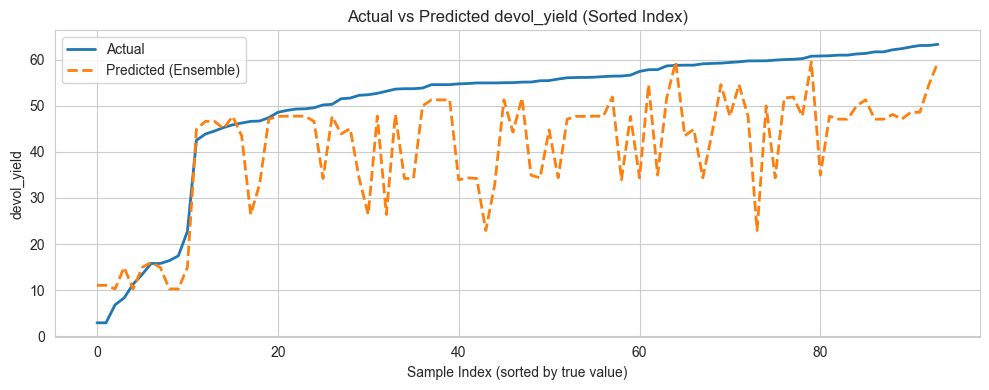

In [62]:
sorted_idx = np.argsort(y_test.values)
plt.figure(figsize=(10, 4))
plt.plot(y_test.values[sorted_idx], label="Actual", linewidth=2)
plt.plot(best_pred[sorted_idx], label="Predicted (Ensemble)", linestyle='--', linewidth=2)
plt.legend()
plt.title("Actual vs Predicted devol_yield (Sorted Index)")
plt.xlabel("Sample Index (sorted by true value)")
plt.ylabel("devol_yield")
plt.grid(True)
plt.tight_layout()
plt.show()


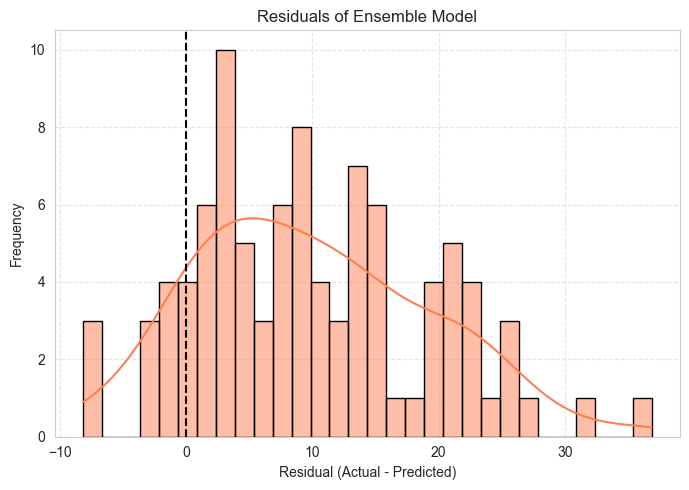

In [63]:
residuals_stack = y_test - best_pred

plt.figure(figsize=(7, 5))
sns.histplot(residuals_stack, bins=30, kde=True, color="coral", edgecolor="black")
plt.axvline(0, color='k', linestyle='--')
plt.title("Residuals of Ensemble Model")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

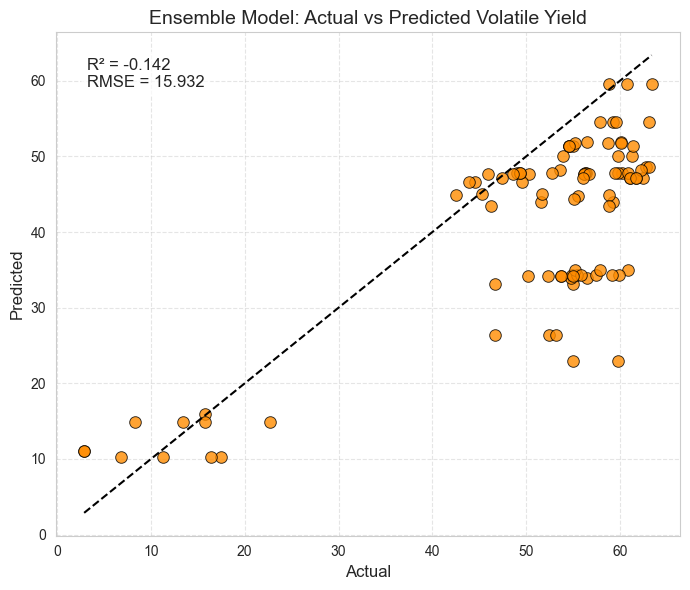

In [64]:
r2 = ensemble_metrics["R2"]
rmse = ensemble_metrics["RMSE"]

plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_test, y=best_pred, color="darkorange", edgecolor="black", s=70, alpha=0.8)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', linewidth=1.5)
plt.title("Ensemble Model: Actual vs Predicted Volatile Yield", fontsize=14)
plt.xlabel("Actual", fontsize=12)
plt.ylabel("Predicted", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Add metrics to the plot
plt.text(
    0.05, 0.95, f"R² = {r2:.3f}\nRMSE = {rmse:.3f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round')
)

plt.tight_layout()
plt.show()


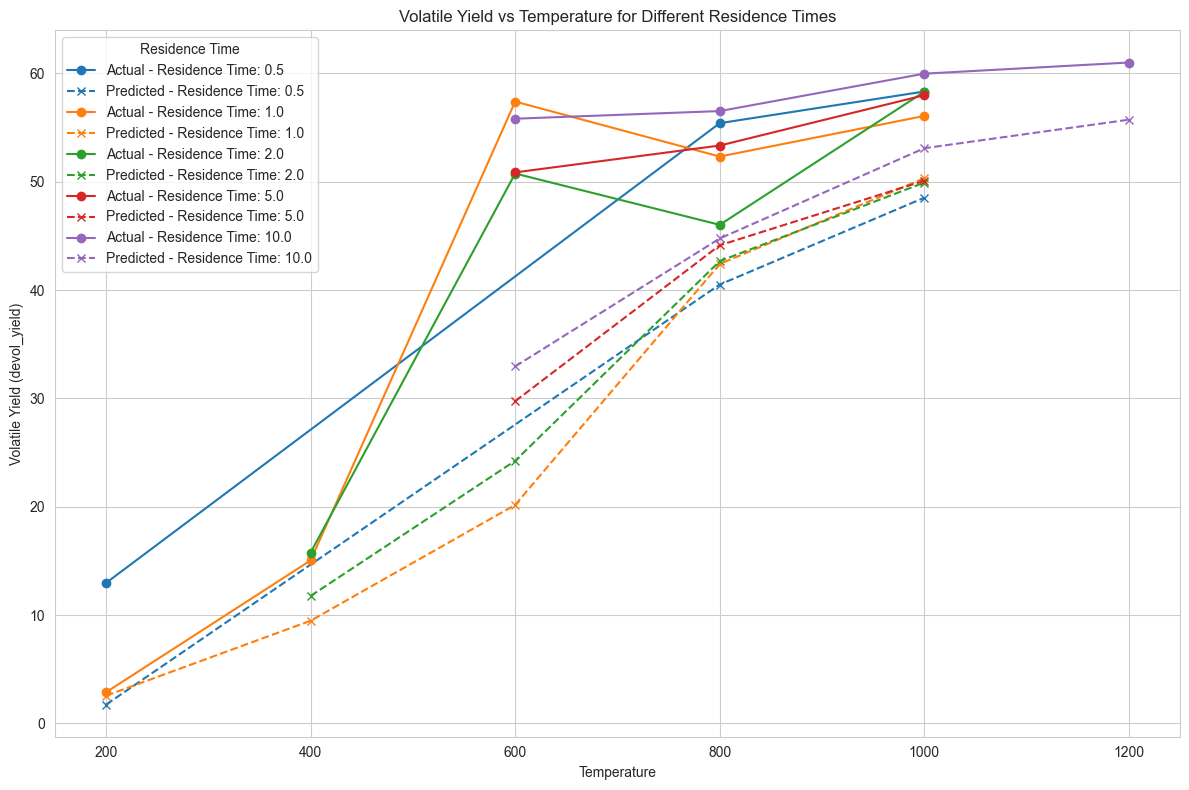

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your data is already loaded in 'test_data' with columns 'residence_time', 'temperature', and 'devol_yield'

# Get predictions from the stacked model (using the same preprocessing steps)
y_pred_stack = np.average([y_pred_mlp, y_pred_lgb, y_pred_gbr, y_pred_xgb], axis=0)

# Add predictions to the test data
test_data['predicted_devol_yield'] = y_pred_stack

# Group by 'residence_time' and 'temperature' to calculate the mean devol_yield and predicted devol_yield
mean_data = test_data.groupby(['residence_time', 'temperature'])['devol_yield'].mean().reset_index()
mean_pred_data = test_data.groupby(['residence_time', 'temperature'])['predicted_devol_yield'].mean().reset_index()

# Set up the plot
plt.figure(figsize=(12, 8))

# Define a color palette for residence_time
palette = sns.color_palette("tab10", n_colors=len(mean_data['residence_time'].unique()))

# Loop through each unique 'residence_time' and plot the mean relationship between temperature and devol_yield
for i, residence_time in enumerate(mean_data['residence_time'].unique()):
    # Filter the mean data for the specific residence_time
    subset = mean_data[mean_data['residence_time'] == residence_time]

    # Plot the relationship between temperature and mean devol_yield for the current residence_time (Actual)
    plt.plot(subset['temperature'], subset['devol_yield'], label=f"Actual - Residence Time: {residence_time}",
             linestyle='-', marker='o', markersize=6, color=palette[i])

    # Plot the relationship between temperature and predicted devol_yield for the current residence_time (Predicted)
    subset_pred = mean_pred_data[mean_pred_data['residence_time'] == residence_time]
    plt.plot(subset_pred['temperature'], subset_pred['predicted_devol_yield'], label=f"Predicted - Residence Time: {residence_time}",
             linestyle='--', marker='x', markersize=6, color=palette[i])

# Add labels and title
plt.xlabel('Temperature')
plt.ylabel('Volatile Yield (devol_yield)')
plt.title('Volatile Yield vs Temperature for Different Residence Times')

# Add a legend
plt.legend(title="Residence Time", loc='best')

# Show the plot
plt.tight_layout()
plt.show()


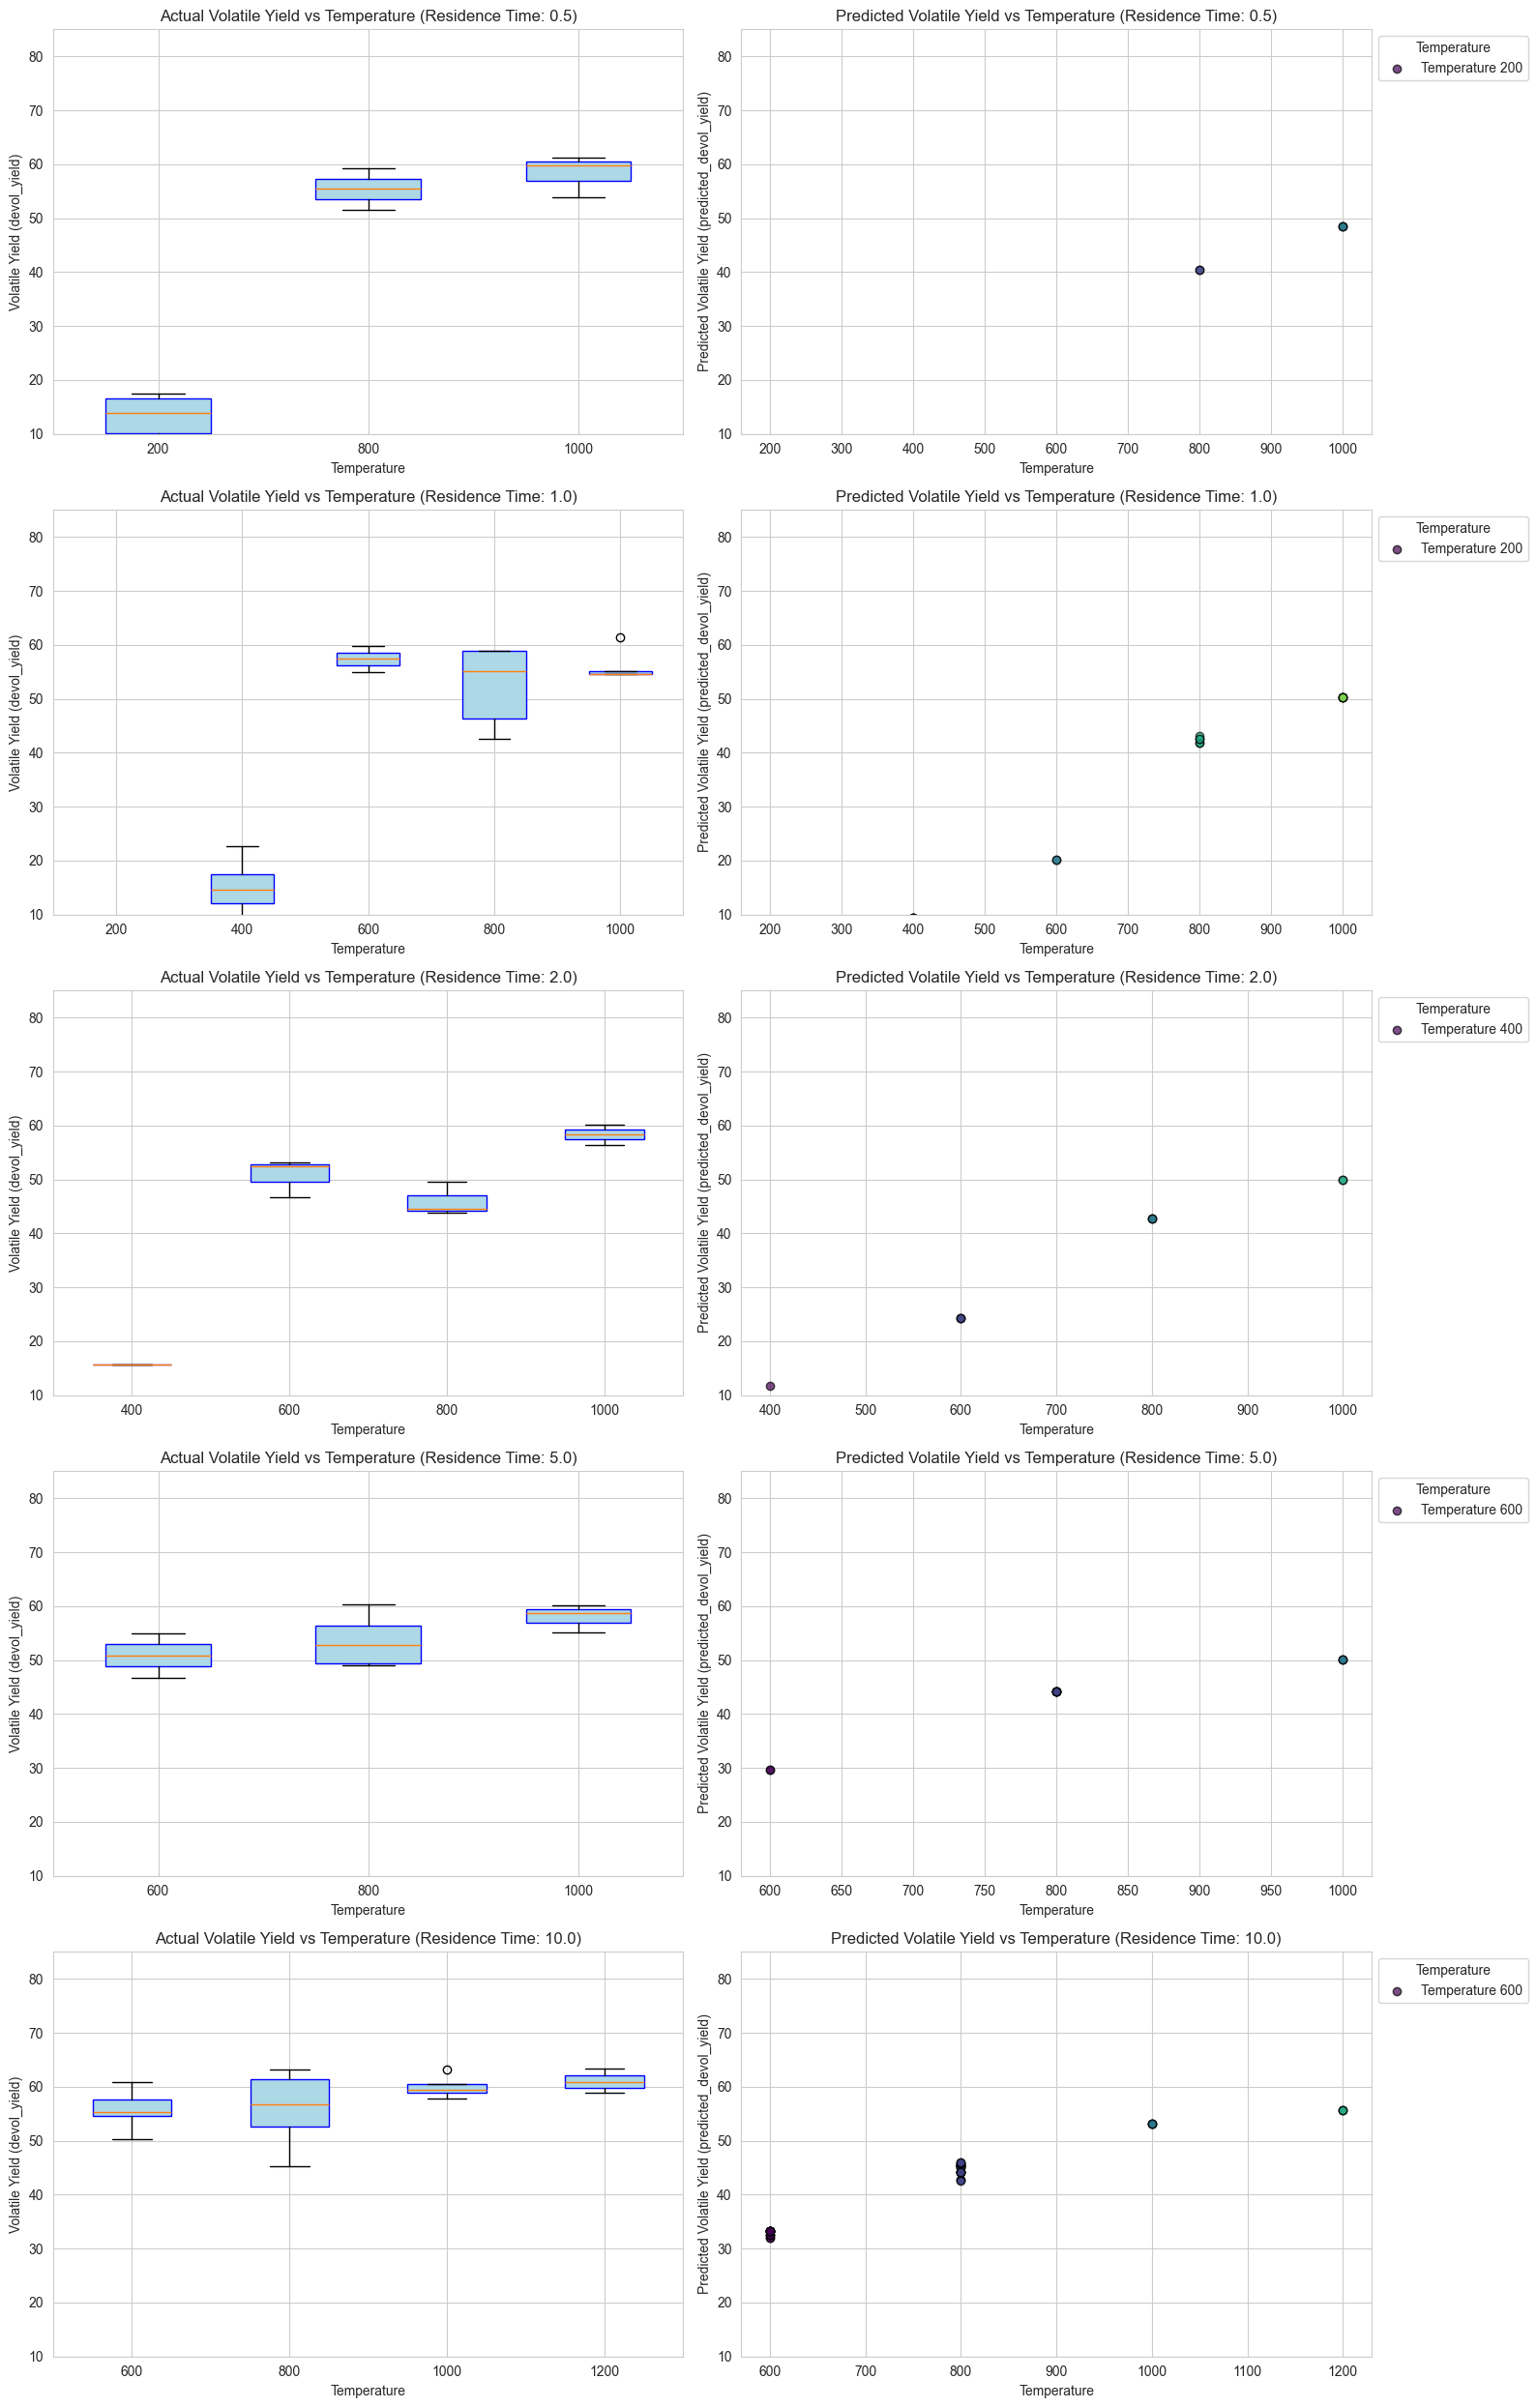

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique residence times
residence_times = test_data['residence_time'].unique()

# Create subplots for each residence_time value
fig, axes = plt.subplots(len(residence_times), 2, figsize=(16, 5 * len(residence_times)))

# Define a custom color palette for the temperature levels
colors = plt.cm.viridis(np.linspace(0, 1, len(test_data['temperature'].unique())))

# Loop over each unique residence_time and plot
for i, residence_time in enumerate(residence_times):
    # Filter the data for the current residence_time
    subset_actual = test_data[test_data['residence_time'] == residence_time]
    subset_predicted = test_data[test_data['residence_time'] == residence_time]

    # --- Plot Actual devol_yield as Box Plot ---
    # Create box plot for actual devol_yield
    axes[i, 0].boxplot([subset_actual[subset_actual['temperature'] == temp]['devol_yield'].values
                        for temp in subset_actual['temperature'].unique()],
                       positions=np.arange(len(subset_actual['temperature'].unique())),
                       widths=0.5, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'))
    axes[i, 0].set_xticks(np.arange(len(subset_actual['temperature'].unique())))
    axes[i, 0].set_xticklabels(subset_actual['temperature'].unique())
    axes[i, 0].set_title(f'Actual Volatile Yield vs Temperature (Residence Time: {residence_time})')
    axes[i, 0].set_xlabel('Temperature')
    axes[i, 0].set_ylabel('Volatile Yield (devol_yield)')
    axes[i, 0].set_ylim(10, 85)  # Set y-axis from 0 to 85

    # --- Plot Predicted devol_yield as Scatter Plot ---
    # Create scatter plot for predicted devol_yield
    for j, temp in enumerate(subset_predicted['temperature'].unique()):
        temp_data = subset_predicted[subset_predicted['temperature'] == temp]
        axes[i, 1].scatter([temp] * len(temp_data), temp_data['predicted_devol_yield'],
                           color=colors[j], label=f'Temperature {temp}' if j == 0 else "", alpha=0.7, edgecolors='k')

    axes[i, 1].set_title(f'Predicted Volatile Yield vs Temperature (Residence Time: {residence_time})')
    axes[i, 1].set_xlabel('Temperature')
    axes[i, 1].set_ylabel('Predicted Volatile Yield (predicted_devol_yield)')
    axes[i, 1].legend(title="Temperature", loc='upper left', bbox_to_anchor=(1, 1))
    axes[i, 1].set_ylim(10, 85)  # Set y-axis from 0 to 85

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


In [67]:
pd.unique(data['fuel_type'].unique())

array(['digestate_car', 'digestate_pe', 'digestate_pp'], dtype=object)